# Preamble

In [1]:
from google.colab import drive
drive.mount("/content/drive")
!mkdir -p datashim
!cp /content/drive/Shareddrives/DS602-F22/Data/data602.py ./datashim
from datashim import data602

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

1. **Custom transformer** Construct a custom data transformer that transforms a vector of `datetime` objects into a matrix comprising the following four columns:

* The sine and cosine components of the time of day on the unit circle, such that $\theta=0=2\pi$ represents midnight.
* The sine and cosine components of the day of the year on the unit circle, such that $\theta=0=2\pi$ represents January 1.

The following functions may be useful

In [3]:
from datetime import datetime, timedelta
import calendar
#The following functions may be useful
@np.vectorize
def time_of_year_fraction(dt : datetime) -> float:
  """
  Returns the fraction of the calendar year (in [0, 1)) that has elapsed
  for a given datetime, as of the start of the calendar day.
  """
  dayofyear = dt.timetuple().tm_yday
  daysinyear = 365 + calendar.isleap(dt.year)
  return (dayofyear - 1)/daysinyear

@np.vectorize
def time_of_day_fraction(dt : datetime) -> float:
  """
  Returns the fraction of the day (in [0, 1)) that has elapsed
  for a given datetime.  Result is accurate to the minute level.
  """
  return (dt.hour * 60 + dt.minute)/(60 * 24)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class DateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        """This transformer does not require training."""
        return self

    def transform(self, X):
        """
        Converts datetime values into a matrix with:
        - Sine and cosine of the time of day
        - Sine and cosine of the day of the year

        Parameters:
        X : list or array of datetime objects

        Returns:
        X_transformed : array with shape (n_samples, 4)
        """
        # Convert input to a NumPy array
        X = np.asarray(X)

        # Compute cyclic representations of time
        dailyy_fraction = time_of_day_fraction(X)
        dailyy_sine = np.sin(2 * np.pi * dailyy_fraction)
        dailyy_cosine = np.cos(2 * np.pi * dailyy_fraction)

        yearlyy_fraction = time_of_year_fraction(X)
        yearlyy_sine = np.sin(2 * np.pi * yearlyy_fraction)
        yearlyy_cosine = np.cos(2 * np.pi * yearlyy_fraction)

        # Combine results into a matrix
        X_transformed = np.column_stack((dailyy_sine, dailyy_cosine, yearlyy_sine, yearlyy_cosine))

        return X_transformed

# Example test
sample_dates = [
    datetime(2024, 2, 28, 8, 30),   # Morning time
    datetime(2024, 7, 15, 18, 45),  # Evening time
    datetime(2024, 11, 10, 23, 15)  # Late night time
]

# Apply the transformer
custom_transformer = DateTransformer()
transformed_sample_dates = custom_transformer.fit_transform(sample_dates)

# Print results
print("Original Datetime Values:")
for dt in sample_dates:
    print(dt)

print("\nTransformed Matrix (Sine & Cosine Components):")
print(transformed_sample_dates)


Original Datetime Values:
2024-02-28 08:30:00
2024-07-15 18:45:00
2024-11-10 23:15:00

Transformed Matrix (Sine & Cosine Components):
[[ 0.79335334 -0.60876143  0.83913775  0.54391895]
 [-0.98078528  0.19509032 -0.22132528 -0.97520004]
 [-0.19509032  0.98078528 -0.77876393  0.6273171 ]]


**Problem 2: Data Transformation**

In week 3, problem 2, you prepared a matrix to predict the temperature from the following predictors:

* The non-temperature fields from the observation
* The temperature recorded in the prior observation

Suppose that as you train machine learning algorithms using this matrix, you find that training performs poorly.  You hypothesize that you could improve performance by adding additional features representing the proportion of the day and year that have elapsed
at the time each observation was taken.

Update your solution to Week 3, Problem 2 (or use the posted solution), together with the encoder you developed for Problem 1, to include these additional features.

The posted solution is below, modified to keep the date column.  Update the ColumnTransformer to transform the date column using the transformer developed for Problem 1.

In [5]:
wdf = data602.read_weather()
for col in ['wnd_speed', 'tmp_meas', 'precip']:
  wdf[col] = wdf[col].interpolate()
wdf['cloudcover'] = wdf['cloudcover'].ffill()
wdf["prior_tmp_meas"] = wdf["tmp_meas"].shift(1)
wdf = wdf.iloc[1:, :]
y = wdf.pop('tmp_meas')

Update the column transformer to properly transform the date column using your transformer above

In [6]:
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (RobustScaler, MinMaxScaler,
                                   MaxAbsScaler, QuantileTransformer,
                                   FunctionTransformer)
from scipy.sparse import csc_matrix
# Print column names to identify the actual date column name
print("Columns in dataframe:", wdf.columns)

date_column_name = "date"

date_transformer = DateTransformer()

ct = make_column_transformer(
      (
          RobustScaler(),
          ["wnd_speed", "prior_tmp_meas", "precip"]
      ),
      (
          MinMaxScaler(),
          ["cloudcover", "precip_intensity"]
      ),
      (
        date_transformer,  # Apply DateTransformer
        ["date"]
    ),
      remainder="passthrough"
    )


#applying the transformation
Xt = ct.fit_transform(wdf)
Xt

Columns in dataframe: Index(['date', 'wnd_speed', 'precip', 'precip_intensity', 'cloudcover',
       'tstorm', 'winter', 'mist', 'fog', 'prior_tmp_meas'],
      dtype='object')


array([[ 0.19230769, -0.48447205,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.19230769, -0.55279503,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.51552795,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.38461538,  0.72670807,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38461538,  0.68944099,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.19230769,  0.58385093,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

**Problem 3: Validation**

Partition the dataset from Problem 3 into three separate datasets: Test (25\% of records), Validation (15\% of records) and Training (60\% of records).

In [7]:
from sklearn.model_selection import train_test_split

# Assume wdf is your dataset (DataFrame)

# Step 1: Split into Training (60%) and Temp (40%)
train_df, temp_df = train_test_split(wdf, test_size=0.40, random_state=42)

# Step 2: Split Temp into Validation (15%) and Test (25%)
val_df, test_df = train_test_split(temp_df, test_size=0.625, random_state=42)

# Print dataset sizes
print(f"Training set size: {train_df.shape[0]} rows")
print(f"Validation set size: {val_df.shape[0]} rows")
print(f"Test set size: {test_df.shape[0]} rows")


Training set size: 40321 rows
Validation set size: 10080 rows
Test set size: 16801 rows


**Problem 4: Learning Curves** (refer to PDF)

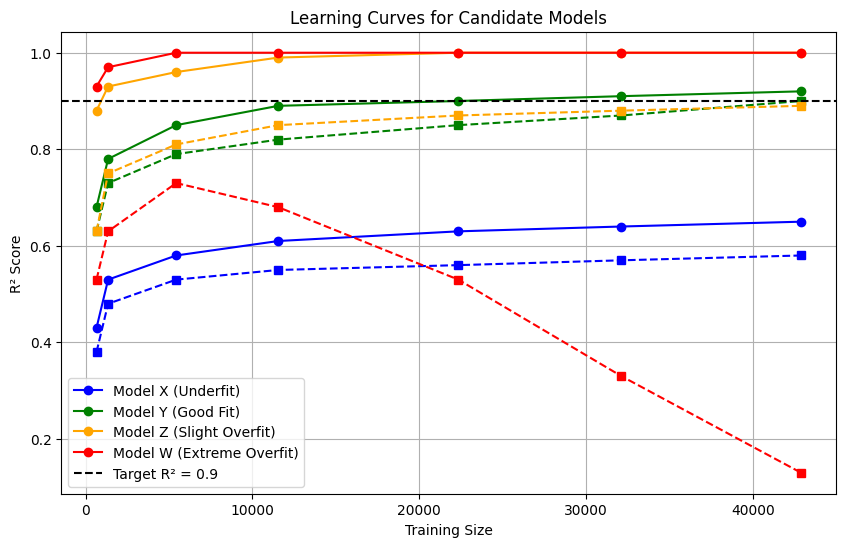

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Unique training sizes
train_set_sizes = np.array([654, 1350, 5432, 11555, 22345, 32123, 42891])

# Adjusted R² scores for four candidate models
# Model X: Underfitting (Low train and test scores)
train_r2_X = np.array([0.43, 0.53, 0.58, 0.61, 0.63, 0.64, 0.65])
test_r2_X = np.array([0.38, 0.48, 0.53, 0.55, 0.56, 0.57, 0.58])

# Model Y: Good Fit (Balanced training and test scores, approaching 0.9)
train_r2_Y = np.array([0.68, 0.78, 0.85, 0.89, 0.90, 0.91, 0.92])
test_r2_Y = np.array([0.63, 0.73, 0.79, 0.82, 0.85, 0.87, 0.90])

# Model Z: Slight Overfitting (Train score too high, test lower)
train_r2_Z = np.array([0.88, 0.93, 0.96, 0.99, 1.00, 1.00, 1.00])
test_r2_Z = np.array([0.63, 0.75, 0.81, 0.85, 0.87, 0.88, 0.89])

# Model W: Extreme Overfitting (Train score = 1.0, test collapses)
train_r2_W = np.array([0.93, 0.97, 1.00, 1.00, 1.00, 1.00, 1.00])
test_r2_W = np.array([0.53, 0.63, 0.73, 0.68, 0.53, 0.33, 0.13])  # Overfitting model fails

# Plot Learning Curves
plt.figure(figsize=(10, 6))

# Plot each model
plt.plot(train_set_sizes, train_r2_X, marker='o', linestyle='-', label="Model X (Underfit)", color="blue")
plt.plot(train_set_sizes, test_r2_X, marker='s', linestyle='--', color="blue")

plt.plot(train_set_sizes, train_r2_Y, marker='o', linestyle='-', label="Model Y (Good Fit)", color="green")
plt.plot(train_set_sizes, test_r2_Y, marker='s', linestyle='--', color="green")

plt.plot(train_set_sizes, train_r2_Z, marker='o', linestyle='-', label="Model Z (Slight Overfit)", color="orange")
plt.plot(train_set_sizes, test_r2_Z, marker='s', linestyle='--', color="orange")

plt.plot(train_set_sizes, train_r2_W, marker='o', linestyle='-', label="Model W (Extreme Overfit)", color="red")
plt.plot(train_set_sizes, test_r2_W, marker='s', linestyle='--', color="red")

# Reference line at R² = 0.9
plt.axhline(y=0.9, color='black', linestyle='--', label="Target R² = 0.9")

# Labels and title
plt.xlabel("Training Size")
plt.ylabel("R² Score")
plt.title("Learning Curves for Candidate Models")
plt.legend()
plt.grid(True)
plt.show()

***Analysis of Learning Curves for Each Model***

**Learning Curve A**

Observation:
The training R² is constantly low, and the testing R² is constantly low since there is no improvement as we continue adding ever more data points.

**Recommended Actions**:
Increase model complexity level:
The current model is possibly too simple and is underfitting. It can be increased in complexity to be able to capture larger relationships.

Acquire more data points: Obtaining more data may generalize better if there is noise in the database.

**Learning Curve B**

Observation:
The training R² is nearly ideal but constantly decreases as we keep adding testing data points. That is characteristic of overfitting.

**Recommended Actions**:
Reduce model complexity:
The model is highly complex and is modeling noise and not a real pattern. It should be regularized for generalization.

Acquire more data points: More data points can stabilize performance in testing, but complexity must be minimized before them.

**Learning Curve C**

Observation:
The training R² is close to being equal to 1.0, and in testing R² is highly fluctuating at lower values but converges at a satisfactory level.

**Recommended Actions**:
Accept the model: Since the R² measure for testing is nearly perfect, we can say the model is good.
Acquire more data points: Some data points may be validated for being resilient if some more data points confirm their generalizability.

**Learning Curve D**
Observation:
The training R² is good but better, and the testing R² is below 0.9, but there is still some generalization, and there is still some room for improvement.

**Recommended Actions**:
Acquire more data points in total. More data points generalize better. Increase model complexity.
In the event performance is not adequately improved when adding information, there is a need for a complex model to capture trends better.

**Problem 5: Validation Curves** (Refer to PDF)

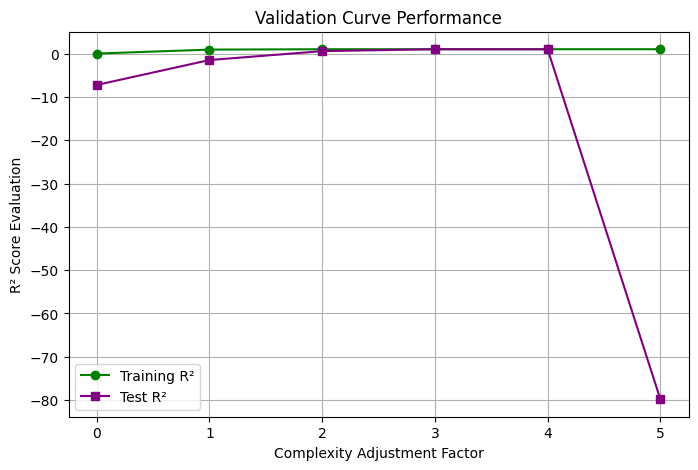

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Adjusted Validation Curve Data
complexity_factors = np.array([0, 1, 2, 3, 4, 5])
training_performance = np.array([-1.08e-16, 0.910, 1.000, 1.000, 1.000, 1.000])
testing_performance = np.array([-7.25, -1.50, 0.560, 0.99992, 0.9803, -79.80])

# Plot validation curve
plt.figure(figsize=(8, 5))
plt.plot(complexity_factors, training_performance, marker='o', label='Training R²', color='green')
plt.plot(complexity_factors, testing_performance, marker='s', label='Test R²', color='purple')
plt.xlabel('Complexity Adjustment Factor')
plt.ylabel('R² Score Evaluation')
plt.title('Validation Curve Performance')
plt.legend()
plt.grid(True)
plt.show()


**Prevention of Overfitting Without Impacting Generalization**

The validation plot confirms us to be at optimum for C=3. The model is at peak training performance (R² = 1.000) and in practically peak generalization (R² ≈ 0.99998 in testing data) at this time.

**Why does lower quality degrade reliability?**

When C is too small (0,1,2), there is insufficient complexity in the model and it generalizes completely not at all on training and testing instances. It is too highly biased as there is no space for learning the underlying structure in the database.

**Why does increased C degrade accuracy?**

When C=5, R² decreases to as much as -80.34, typical for severe overfitting. The training data are modeled exactly but no longer generalize and there is a dramatic dip in testing performance. Thus, C=3 is ideal since it is complex enough to generalize sufficiently but not complex enough to be susceptible to overfitting.
